In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing
import matplotlib.pyplot as plt


In [2]:
data = pd.read_csv('TrainingSet.csv')
test = pd.read_csv('SubmissionRows.csv')

In [3]:
data.shape

(195402, 40)

In [4]:
data.head()

,Unnamed: 0,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.769214,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.027746,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.244887,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.933105,Afghanistan,allsi.gen_pop,(%) Generosity of All Social Insurance
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.996814,Afghanistan,allsp.gen_pop,(%) Generosity of All Social Protection


In [5]:
test.shape

(737, 3)

In [6]:
trainingData = data.copy()

In [7]:
trainingData.columns

Index(['Unnamed: 0', '1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]',
       '1975 [YR1975]', '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]',
       '1979 [YR1979]', '1980 [YR1980]', '1981 [YR1981]', '1982 [YR1982]',
       '1983 [YR1983]', '1984 [YR1984]', '1985 [YR1985]', '1986 [YR1986]',
       '1987 [YR1987]', '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]',
       '1991 [YR1991]', '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]',
       '1995 [YR1995]', '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]',
       '1999 [YR1999]', '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]',
       '2003 [YR2003]', '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]',
       '2007 [YR2007]', 'Country Name', 'Series Code', 'Series Name'],
      dtype='object')

In [8]:
def setLogVal(X,colName):
    X=X.mask(X==0,1)
    if(X.name == colName):
        X = np.log10(X)
    return X

def cleanData(data,targetCol,dropCol,threshold =10, training = True):
    #targetColList = [targetCol]
    if(training == True):
        data = data.dropna(subset=[targetCol]) # will drop all rows with na values for this column
    data = data.dropna(how='all') #will drop all rows which have na values for all columns in dataframe
    #data = data.dropna(thresh=threshold) # will drop all rows which have total na values in columns greater than threshold
    # dont need indicator as this is just like index and has different number for same series and different countries
    data = data.drop(dropCol, axis=1) 
    # get log value of y(2007) and drop all NAN
    if(training == True):
        data = data.apply(lambda x: setLogVal(x,targetCol),axis=0)
        data = data.dropna(subset = [targetCol]) # to remove all NAN due to log value
        y = data[targetCol]
    else:
        y = None
    return data,y


    

    

In [9]:
def preprocessData(data, NAHandlingMethod, scaler,training = True):
    # if preparing training data numeric data does not include 2007 else all years are numeric data
    if(training == True):
        data_num = data.iloc[:,:-3]
        data_cat = data.iloc[:,-2:]
    else:
        data_num = data.iloc[:,:-2]
        data_cat = data.iloc[:,-2:]
    print('numeric columns are : ', data_num.columns)
    print('categorical columns are : ', data_cat.columns)
    if(NAHandlingMethod == 'mean'):
        data_num = data_num.apply(lambda x: x.fillna(x.mean(),axis=0))
    else:
        data_num = data_num.apply(lambda x: x.fillna(0),axis=0)
    data_num = data_num.round(2)
    data_num_scaled= scaler.fit_transform(data_num)
    data_cat = pd.get_dummies(data_cat)
    data_num_scaled_df= pd.DataFrame(data_num_scaled,columns=data_num.columns,index=data_num.index)
    data_traininable = data_num_scaled_df.merge(data_cat,left_index=True,right_index=True)
    return data_traininable

In [10]:
def getTrainableData(data,scaler,NAHandlingMethod,dropRowsAllNAFromCol,threshold,dropCol):
    X,y = cleanData(data,dropRowsAllNAFromCol,dropCol,threshold,True)
    X = preprocessData(X,0,scaler,True)
    X_train,y_train,X_val,y_val = X[:100000],y[:100000],X[100000:],y[100000:]
    return X_train,y_train,X_val,y_val
    
    
    

In [11]:
min_max_scaler = preprocessing.MinMaxScaler()
X_train,y_train,X_val,y_val = getTrainableData(trainingData,min_max_scaler,NAHandlingMethod=None,dropRowsAllNAFromCol='2007 [YR2007]',threshold=10,dropCol=["Series Name","Unnamed: 0"])




/Users/ushadevi/HandsOnML/Chapter2/Example/MLenv/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


numeric columns are :  Index(['1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]', '1975 [YR1975]',
       '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]', '1979 [YR1979]',
       '1980 [YR1980]', '1981 [YR1981]', '1982 [YR1982]', '1983 [YR1983]',
       '1984 [YR1984]', '1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]',
       '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]', '1991 [YR1991]',
       '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]', '1995 [YR1995]',
       '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]',
       '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]',
       '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]'],
      dtype='object')
categorical columns are :  Index(['Country Name', 'Series Code'], dtype='object')


In [12]:
y_train.describe()


count    100000.000000
mean          3.681606
std           3.886242
min         -17.061800
25%           0.843839
50%           1.810233
75%           7.225057
max          15.596695
Name: 2007 [YR2007], dtype: float64

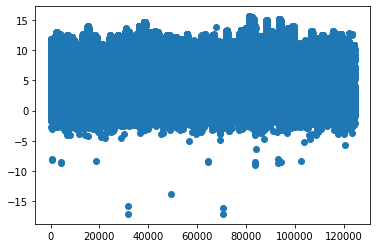

In [13]:
plt.scatter(y_train.index,y_train)

In [14]:
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((100000, 1510), (100000,), (55772, 1510), (55772,))

In [15]:
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(X_train.shape[1],)))
model.add(tf.keras.layers.Dense(200,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(200,activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(1))

opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(loss="mean_squared_error", optimizer=opt)

history = model.fit(X_train,y_train,epochs=100,validation_data=(X_val,y_val))

Epoch 1/100
3125/3125 [==============================] - 19s 6ms/step - loss: 8.0865 - val_loss: 4.6243
Epoch 2/100
3125/3125 [==============================] - 15s 5ms/step - loss: 2.4040 - val_loss: 3.7612
Epoch 3/100
3125/3125 [==============================] - 20s 6ms/step - loss: 1.9972 - val_loss: 3.4321
Epoch 4/100
3125/3125 [==============================] - 15s 5ms/step - loss: 1.7176 - val_loss: 3.2974
Epoch 5/100
3125/3125 [==============================] - 14s 5ms/step - loss: 1.4877 - val_loss: 3.1967
Epoch 6/100
3125/3125 [==============================] - 18s 6ms/step - loss: 1.3611 - val_loss: 3.1469
Epoch 7/100
3125/3125 [==============================] - 16s 5ms/step - loss: 1.2771 - val_loss: 3.1005
Epoch 8/100
3125/3125 [==============================] - 16s 5ms/step - loss: 1.1778 - val_loss: 3.0480
Epoch 9/100
3125/3125 [==============================] - 16s 5ms/step - loss: 1.1254 - val_loss: 3.0611
Epoch 10/100
3125/3125 [==============================] - 16s 5m

3125/3125 [==============================] - 14s 4ms/step - loss: 0.5684 - val_loss: 2.5595
Epoch 80/100
3125/3125 [==============================] - 14s 4ms/step - loss: 0.5549 - val_loss: 2.5968
Epoch 81/100
3125/3125 [==============================] - 16s 5ms/step - loss: 0.5670 - val_loss: 2.5546
Epoch 82/100
3125/3125 [==============================] - 17s 6ms/step - loss: 0.5677 - val_loss: 2.5551
Epoch 83/100
3125/3125 [==============================] - 18s 6ms/step - loss: 0.5628 - val_loss: 2.5604
Epoch 84/100
3125/3125 [==============================] - 15s 5ms/step - loss: 0.5706 - val_loss: 2.5370
Epoch 85/100
3125/3125 [==============================] - 14s 5ms/step - loss: 0.5360 - val_loss: 2.5409
Epoch 86/100
3125/3125 [==============================] - 14s 4ms/step - loss: 0.5534 - val_loss: 2.5506
Epoch 87/100
3125/3125 [==============================] - 14s 4ms/step - loss: 0.5574 - val_loss: 2.5682
Epoch 88/100
3125/3125 [==============================] - 14s 4ms/st

In [16]:
prediction = model.predict(X_val[:5])

In [54]:
first_five = prediction

In [57]:
first_five_val = np.power(10,first_five)

In [58]:
first_five_val

array([[1.7049284e+05],
       [2.4034834e+01],
       [2.2632375e+04],
       [8.5367494e+08],
       [1.9981154e+07]], dtype=float32)

In [61]:
first_five_y_val = np.power(10,y_val)

In [63]:
first_five_y_val[:5]

124616    1.581620e+05
124617    5.385554e+01
124618    6.423000e+03
124623    1.052675e+09
124624    4.385741e+06
Name: 2007 [YR2007], dtype: float64

In [17]:
prediction

array([[5.231706 ],
       [1.3808411],
       [4.35473  ],
       [8.931293 ],
       [7.3006206]], dtype=float32)

In [18]:
y_val[:5]

124616    5.199102
124617    1.731230
124618    3.807738
124623    9.022294
124624    6.642043
Name: 2007 [YR2007], dtype: float64

In [19]:
test.head()

,Unnamed: 0,2008 [YR2008],2012 [YR2012]
0,559,NaN,NaN
1,618,NaN,NaN
2,753,NaN,NaN
3,1030,NaN,NaN
4,1896,NaN,NaN


In [20]:
data.head()

,Unnamed: 0,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,3.769214,Afghanistan,allsi.bi_q1,(%) Benefits held by 1st 20% population - All ...
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.027746,Afghanistan,allsp.bi_q1,(%) Benefits held by 1st 20% population - All ...
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,8.244887,Afghanistan,allsa.bi_q1,(%) Benefits held by 1st 20% population - All ...
3,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,12.933105,Afghanistan,allsi.gen_pop,(%) Generosity of All Social Insurance
4,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,18.996814,Afghanistan,allsp.gen_pop,(%) Generosity of All Social Protection


In [21]:
#merge test data to get all columns
test_all_cols = data.merge(test,on='Unnamed: 0')
sliced = data[data['Unnamed: 0'].isin(test['Unnamed: 0'])]

In [22]:
test_indexes = sliced.index

In [23]:
def getTestableData(data,scaler,NAHandlingMethod,dropRowsAllNAFromCol,threshold,dropCol):
    X,y = cleanData(data,dropRowsAllNAFromCol,dropCol,threshold,False)
    X = preprocessData(X,0,scaler,False)
    return X

In [24]:
testingData = data.copy()
testingData = testingData.iloc[:,0:]
testingData.columns



Index(['Unnamed: 0', '1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]',
       '1975 [YR1975]', '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]',
       '1979 [YR1979]', '1980 [YR1980]', '1981 [YR1981]', '1982 [YR1982]',
       '1983 [YR1983]', '1984 [YR1984]', '1985 [YR1985]', '1986 [YR1986]',
       '1987 [YR1987]', '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]',
       '1991 [YR1991]', '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]',
       '1995 [YR1995]', '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]',
       '1999 [YR1999]', '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]',
       '2003 [YR2003]', '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]',
       '2007 [YR2007]', 'Country Name', 'Series Code', 'Series Name'],
      dtype='object')

In [25]:
testingData = testingData.drop(columns=['1972 [YR1972]'])

In [26]:
X_test = getTestableData(testingData,min_max_scaler,NAHandlingMethod=None,dropRowsAllNAFromCol=None,threshold=10,dropCol=["Series Name","Unnamed: 0"])



numeric columns are :  Index(['1973 [YR1973]', '1974 [YR1974]', '1975 [YR1975]', '1976 [YR1976]',
       '1977 [YR1977]', '1978 [YR1978]', '1979 [YR1979]', '1980 [YR1980]',
       '1981 [YR1981]', '1982 [YR1982]', '1983 [YR1983]', '1984 [YR1984]',
       '1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]', '1988 [YR1988]',
       '1989 [YR1989]', '1990 [YR1990]', '1991 [YR1991]', '1992 [YR1992]',
       '1993 [YR1993]', '1994 [YR1994]', '1995 [YR1995]', '1996 [YR1996]',
       '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]', '2000 [YR2000]',
       '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]', '2004 [YR2004]',
       '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]'],
      dtype='object')
categorical columns are :  Index(['Country Name', 'Series Code'], dtype='object')


In [27]:
X_test.shape

(195402, 1554)

In [28]:
extraCol = set(X_test.columns) - set(X_train.columns)


In [29]:
extraCol.remove('2007 [YR2007]')

In [30]:
X_test = X_test.drop(columns=extraCol)

In [31]:
X_test.shape,X_train.shape

((195402, 1510), (100000, 1510))

In [32]:
predictions = model.predict(X_test)

In [33]:
predictions

array([[3.7453923],
       [3.4441092],
       [3.7433083],
       ...,
       [4.848891 ],
       [4.4785056],
       [4.713124 ]], dtype=float32)

In [34]:
X_toPred = X_test.iloc[test_indexes]

In [35]:
X_toPred.shape

(737, 1510)

In [36]:
test_predictions_2008 = model.predict(X_toPred)

In [37]:
test_predictions_2008_val = np.power(10,test_predictions_2008)

In [38]:
np.min(test_predictions_2008),np.max(test_predictions_2008)

(0.07709873, 4.2347264)

In [39]:
test_predictions_2008_val = test_predictions_2008_val.round(2)

In [40]:
np.min(test_predictions_2008_val),np.max(test_predictions_2008_val)

(1.19, 17168.26)

In [41]:
data.describe()

,Unnamed: 0,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],...,1998 [YR1998],1999 [YR1999],2000 [YR2000],2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007]
count,195402.000000,6.494500e+04,6.444300e+04,6.496600e+04,6.697300e+04,6.771700e+04,6.973500e+04,6.976300e+04,6.990600e+04,7.525000e+04,...,1.259440e+05,1.308800e+05,1.405470e+05,1.367830e+05,1.403150e+05,1.391590e+05,1.423790e+05,1.615440e+05,1.588880e+05,1.615960e+05
mean,141942.303426,1.630638e+11,1.839488e+11,2.089534e+11,2.148826e+11,2.321517e+11,2.413682e+11,2.540583e+11,2.742810e+11,2.674858e+11,...,7.079045e+11,7.214590e+11,7.396189e+11,8.236331e+11,8.834342e+11,9.691983e+11,1.054572e+12,1.057680e+12,1.203163e+12,1.353147e+12
std,82594.568035,4.261616e+12,4.749746e+12,5.378336e+12,5.647070e+12,6.120314e+12,6.398377e+12,6.710724e+12,7.213662e+12,7.381164e+12,...,1.927225e+13,1.975110e+13,2.055262e+13,2.240717e+13,2.412411e+13,2.612031e+13,2.874833e+13,3.047457e+13,3.469590e+13,4.002108e+13
min,0.000000,-1.047939e+14,-1.128889e+14,-7.134161e+13,-8.269588e+13,-9.735652e+13,-9.433422e+13,-9.495898e+13,-5.362479e+13,-5.649790e+13,...,-1.014742e+14,-9.646140e+13,-9.216180e+13,-6.621060e+13,-5.635700e+13,-1.853552e+14,-1.515222e+14,-1.350005e+14,-1.422689e+14,-1.691820e+14
25%,70571.250000,3.176702e+00,3.550009e+00,4.000000e+00,3.671917e+00,4.595300e+00,5.000000e+00,4.901495e+00,5.000000e+00,5.682373e+00,...,4.902281e+00,5.264969e+00,5.304083e+00,5.249579e+00,5.269189e+00,5.500000e+00,5.460000e+00,5.206670e+00,5.206982e+00,5.000000e+00
50%,141554.500000,6.394000e+01,6.631737e+01,7.048563e+01,7.188613e+01,7.456354e+01,7.894462e+01,7.863808e+01,8.140866e+01,8.182969e+01,...,6.423599e+01,6.570000e+01,6.270796e+01,6.391600e+01,6.330000e+01,6.452287e+01,6.290620e+01,5.737856e+01,5.547417e+01,5.504303e+01
75%,211984.750000,5.007000e+06,7.131000e+06,9.250000e+06,1.108200e+07,1.290000e+07,1.540950e+07,1.922850e+07,2.409375e+07,2.419225e+07,...,1.870445e+07,1.300000e+07,6.544000e+06,1.038850e+07,9.278000e+06,1.200000e+07,1.066050e+07,8.484250e+06,1.025022e+07,8.599101e+06
max,286117.000000,2.681335e+14,2.943467e+14,3.186506e+14,3.383541e+14,3.586152e+14,3.895869e+14,4.254506e+14,4.556262e+14,5.039050e+14,...,1.348416e+15,1.324599e+15,1.389770e+15,1.646322e+15,1.821833e+15,2.013675e+15,2.295826e+15,2.774281e+15,3.339217e+15,3.950893e+15


In [42]:
years = ['2008 [YR2008]','2009 [YR2009]','2010 [YR2010]','2011 [YR2011]','2012 [YR2012]']
drop_years = ['1972 [YR1972]','1973 [YR1973]','1974 [YR1974]','1975 [YR1975]','1976 [YR1976]']
all_years = data.columns

all_years

Index(['Unnamed: 0', '1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]',
       '1975 [YR1975]', '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]',
       '1979 [YR1979]', '1980 [YR1980]', '1981 [YR1981]', '1982 [YR1982]',
       '1983 [YR1983]', '1984 [YR1984]', '1985 [YR1985]', '1986 [YR1986]',
       '1987 [YR1987]', '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]',
       '1991 [YR1991]', '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]',
       '1995 [YR1995]', '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]',
       '1999 [YR1999]', '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]',
       '2003 [YR2003]', '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]',
       '2007 [YR2007]', 'Country Name', 'Series Code', 'Series Name'],
      dtype='object')

In [65]:
years = ['2008 [YR2008]','2009 [YR2009]','2010 [YR2010]','2011 [YR2011]','2012 [YR2012]','2013 [YR2013]']
drop_years = ['1972 [YR1972]','1973 [YR1973]','1974 [YR1974]','1975 [YR1975]','1976 [YR1976]']
all_years = data.columns


def getPredicts(data,drop_years):
    pred = []
    loc = 37
    year = 2008
    for i, v in enumerate(drop_years):
        print(i,v)
        #print('before....', data.columns)
        #print('after....', data.columns)
        X_test = getTestableData(data,min_max_scaler,NAHandlingMethod=None,dropRowsAllNAFromCol=None,threshold=10,dropCol=["Series Name","Unnamed: 0"])
        X_test = X_test.drop(columns=[v])
        extraCol = set(X_test.columns) - set(X_train.columns)
        extraCol.difference_update(all_years)
        extraCol.difference_update(years)
        # remove all extra dummy series code from prepared test data except years columns
        #print('extra col', extraCol)
        X_test = X_test.drop(columns=extraCol)
        # series data absent in prepared test compared to train data
        X_toPred = X_test.iloc[test_indexes]
        #predict full data
        predictions = model.predict(X_test)
        predictions_val = np.power(10,predictions)
        #predict only data in submission file
        predictions_test = model.predict(X_toPred)
        predictions_val_test = np.power(10,predictions_test)
        pred.append(predictions_val_test)
        #add next year in full data for next year
        data.insert(loc,year,predictions_val)
        year = year +1
        loc = loc +1
    return pred
   

In [66]:
testingData = data.copy()
predictions_all = getPredicts(testingData,drop_years)

0 1972 [YR1972]
numeric columns are :  Index(['1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]', '1975 [YR1975]',
       '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]', '1979 [YR1979]',
       '1980 [YR1980]', '1981 [YR1981]', '1982 [YR1982]', '1983 [YR1983]',
       '1984 [YR1984]', '1985 [YR1985]', '1986 [YR1986]', '1987 [YR1987]',
       '1988 [YR1988]', '1989 [YR1989]', '1990 [YR1990]', '1991 [YR1991]',
       '1992 [YR1992]', '1993 [YR1993]', '1994 [YR1994]', '1995 [YR1995]',
       '1996 [YR1996]', '1997 [YR1997]', '1998 [YR1998]', '1999 [YR1999]',
       '2000 [YR2000]', '2001 [YR2001]', '2002 [YR2002]', '2003 [YR2003]',
       '2004 [YR2004]', '2005 [YR2005]', '2006 [YR2006]', '2007 [YR2007]'],
      dtype='object')
categorical columns are :  Index(['Country Name', 'Series Code'], dtype='object')
1 1973 [YR1973]
numeric columns are :  Index(['1972 [YR1972]', '1973 [YR1973]', '1974 [YR1974]', '1975 [YR1975]',
       '1976 [YR1976]', '1977 [YR1977]', '1978 [YR1978]', '1979 [YR

In [45]:
pred_2008 = predictions_all[0]

In [46]:
pred_2008.shape
total = len(predictions_all[0])
total

737

In [47]:
total = len(predictions_all[0])
pred_2008 = predictions_all[0]
pred_2008_reshaped= np.reshape(pred_2008,total)
pred_2012 = predictions_all[4]
pred_2012_reshaped= np.reshape(pred_2012,total)

#X_toPred = X_test.iloc[test_indexes]

result = pd.DataFrame({'':test['Unnamed: 0'],
                    '2008 [YR2008]': pred_2008_reshaped,
                      '2012 [YR2012]': pred_2012_reshaped})

In [48]:
result.to_csv("result",index=False)

In [69]:
data[data['Unnamed: 0']==191809]

,Unnamed: 0,1972 [YR1972],1973 [YR1973],1974 [YR1974],1975 [YR1975],1976 [YR1976],1977 [YR1977],1978 [YR1978],1979 [YR1979],1980 [YR1980],...,2001 [YR2001],2002 [YR2002],2003 [YR2003],2004 [YR2004],2005 [YR2005],2006 [YR2006],2007 [YR2007],Country Name,Series Code,Series Name
132057,191809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.64,0.7284,0.7813,0.7769,0.8199,0.8255,0.8693,Norway,8.16,Develop a global partnership for development: ...


In [68]:
result[500:505]

,,2008 [YR2008],2012 [YR2012]
500,191809,1030.600586,798.158447
501,191944,106.530312,96.865707
502,193087,621.170044,549.753296
503,193146,260.165710,198.747177
504,193281,114.861618,91.942055
